# Relax Challenge Notebook
## Michael Trent
### The purpose of this notebook is to determine the primary factors that predict whether an individual will "adopt" an account with a website. In this case "adoption" means that the individual visted the website three times within a one week span. 

In [1]:
#First import the packages
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import shap

In [2]:
#We need to determine the encoding type using chardet
with open('takehome_users.csv', 'rb') as f:
    result = chardet.detect(f.read())
#Now read in the user data using the encoding found above
users = pd.read_csv('takehome_users.csv', encoding=result['encoding'])

#Repeat the process for the engagement file
with open('takehome_user_engagement.csv', 'rb') as f:
    result = chardet.detect(f.read())
engage = pd.read_csv('takehome_user_engagement.csv', encoding = result['encoding'])

In [3]:
#Lets take a look at the datasets
users.head(5)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [58]:
engage.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
#According to the documentation, the object_id is the same as the user_id. We need to rename that column for clarity
# and join the data on the user id

users.rename(columns = {'object_id' : 'user_id'}, inplace = True)

In [6]:
#Lets take a look at the dimaensions
users.shape

(12000, 10)

In [7]:
#Check for null values
users.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
#check for null values
engage.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [9]:
engage.shape

(207917, 3)

In [10]:
#Join the datasets on the user_id. We'll use an outer join to ensure we don't loose data
df = users.merge(engage, on = 'user_id', how = 'outer')

In [11]:
#Lets see how many null values are in the merged data
df.isnull().sum()

user_id                           0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time     3177
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            92566
time_stamp                     3177
visited                        3177
dtype: int64

In [12]:
df.shape

(211094, 12)

In [13]:
#There appears to be a lot of missing values in the "invited_by_user_id" column. We don't need this column 
#so I'll plan to drop this column. 

df.drop(columns = ['invited_by_user_id'], inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     211094 non-null  int64  
 1   creation_time               211094 non-null  object 
 2   name                        211094 non-null  object 
 3   email                       211094 non-null  object 
 4   creation_source             211094 non-null  object 
 5   last_session_creation_time  207917 non-null  float64
 6   opted_in_to_mailing_list    211094 non-null  int64  
 7   enabled_for_marketing_drip  211094 non-null  int64  
 8   org_id                      211094 non-null  int64  
 9   time_stamp                  207917 non-null  object 
 10  visited                     207917 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.3+ MB


In [15]:
#Now we need to drop na values to avoid any issues with the algorithms

df.dropna(inplace = True)

In [16]:
#Double check that there are no null values at this time
df.isnull().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
time_stamp                    0
visited                       0
dtype: int64

In [17]:
#Let's get an idea of the data types we're looking at
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 211093
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     207917 non-null  int64  
 1   creation_time               207917 non-null  object 
 2   name                        207917 non-null  object 
 3   email                       207917 non-null  object 
 4   creation_source             207917 non-null  object 
 5   last_session_creation_time  207917 non-null  float64
 6   opted_in_to_mailing_list    207917 non-null  int64  
 7   enabled_for_marketing_drip  207917 non-null  int64  
 8   org_id                      207917 non-null  int64  
 9   time_stamp                  207917 non-null  object 
 10  visited                     207917 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.0+ MB


In [18]:
#Now we need to convert the time_stamps into date time objects

df['creation_time'] = pd.to_datetime(df['creation_time'])
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'])
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 211093
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   user_id                     207917 non-null  int64         
 1   creation_time               207917 non-null  datetime64[ns]
 2   name                        207917 non-null  object        
 3   email                       207917 non-null  object        
 4   creation_source             207917 non-null  object        
 5   last_session_creation_time  207917 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   time_stamp                  207917 non-null  datetime64[ns]
 10  visited                     207917 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64

In [21]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,time_stamp,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,2014-04-22 03:53:30,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-11-15 03:45:04,1.0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-11-29 03:45:04,1.0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-12-09 03:45:04,1.0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-12-25 03:45:04,1.0


In [22]:
#We need to calculate the difference between the individual time_stamps for each user
#This time difference will be over three vistsso it will only exist as a value if the 
#user has visted the site more than twice
df['timeDelta'] = df.groupby('user_id').time_stamp.diff(3)

In [23]:
#Insert a column for adopted - this will become the target variable
df.insert(len(df.columns), 'adopted', 0)

In [24]:
#Let's create a series of the users that have 
adopted = df.groupby('user_id').timeDelta.min() <= timedelta(days = 7 )

In [25]:
#For each of the users in the dataset, if they are included in the adopted series, 
#then they have adopted the site (1), otherwise they didn't (0)
for user in df.user_id.unique():
    if adopted[user]:
        df.loc[df['user_id']==user, 'adopted'] = 1

In [26]:
#We need to replace the NaN values in the timeDelta column with 0
df.timeDelta.fillna(timedelta(days = 0), inplace = True)
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,time_stamp,visited,timeDelta,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,2014-04-22 03:53:30,1.0,0 days,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-11-15 03:45:04,1.0,0 days,0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-11-29 03:45:04,1.0,0 days,0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-12-09 03:45:04,1.0,0 days,0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-12-25 03:45:04,1.0,40 days,0


In [27]:
#Now that we have the target variable, we need to start trying to predict the outcome. 
#I suspect the domain from the users email may be predictive of their adoption status 
#of the site. Here I'll engineer a feature that consists of just the email domain.
df['domain'] = df.email.apply(lambda x: re.findall('@(.*?).com', x)[0] if len(re.findall('@(.*?).com', x))> 0 else '')

In [28]:
#perhaps the overall number of visits to the site are predictive 
#Lets engineer a feature for that as well
df['totalVisits'] = df.groupby('user_id').visited.sum()
df.totalVisits.fillna(1, inplace = True)

In [29]:
#Maybe the hour, year and/or month of first visit predict adoption
# We'll engineer three additional variables
df['creationHour'] = df.creation_time.dt.hour
df['creationMonth'] = df.creation_time.dt.month
df['creationYear'] = df.creation_time.dt.year

In [30]:
#I doubt name or email would be predictive so we'll drop them as well as user_id, since they have no 
#interpretive value. 
df.drop(columns = ['name', 'email', 'user_id'], inplace = True)

In [31]:
#for all other categorical variables, we need to create dummies and drop the columns. 
#We also need to replace all NaTs in the timeDelta column with 0.
df.timeDelta.fillna(pd.Timedelta(days=0), inplace = True)
#Convert the timeDelta to int of days
df['timeDelta'] = df.timeDelta.dt.days
#Now we need to get a list of the categorical columns so we can create dummy variables
#Create an empty list
objCols = []
#append the column names for "object" columns
_ = [objCols.append(col) for col in df.columns if df[col].dtype == 'O']
#Create the dummy columns df
dummyCols = df[objCols]
#create the X variables
X = df.drop(columns = objCols)
#Get dummies
dummys = pd.get_dummies(dummyCols)
#Append the dummy variables
X = pd.concat([X, dummys], axis = 1)

In [32]:
#Lets see what we have here. 
X.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,time_stamp,visited,timeDelta,adopted,totalVisits,...,domain_zjwjb,domain_zkbxm,domain_zkbzv,domain_zkcdj,domain_zkcep,domain_zkdih,domain_zpbkw,domain_zpcop,domain_zsrgb,domain_zssin
0,2014-04-22 03:53:30,1970-01-01 00:00:01.398138810,1,0,11,2014-04-22 03:53:30,1.0,0,0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2013-11-15 03:45:04,1970-01-01 00:00:01.396237504,0,0,1,2013-11-15 03:45:04,1.0,0,0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2013-11-15 03:45:04,1970-01-01 00:00:01.396237504,0,0,1,2013-11-29 03:45:04,1.0,0,0,14.0,...,0,0,0,0,0,0,0,0,0,0
3,2013-11-15 03:45:04,1970-01-01 00:00:01.396237504,0,0,1,2013-12-09 03:45:04,1.0,0,0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,2013-11-15 03:45:04,1970-01-01 00:00:01.396237504,0,0,1,2013-12-25 03:45:04,1.0,40,0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Now create the target variable
y = X.adopted.values
X.drop(columns = ['adopted'], inplace = True)

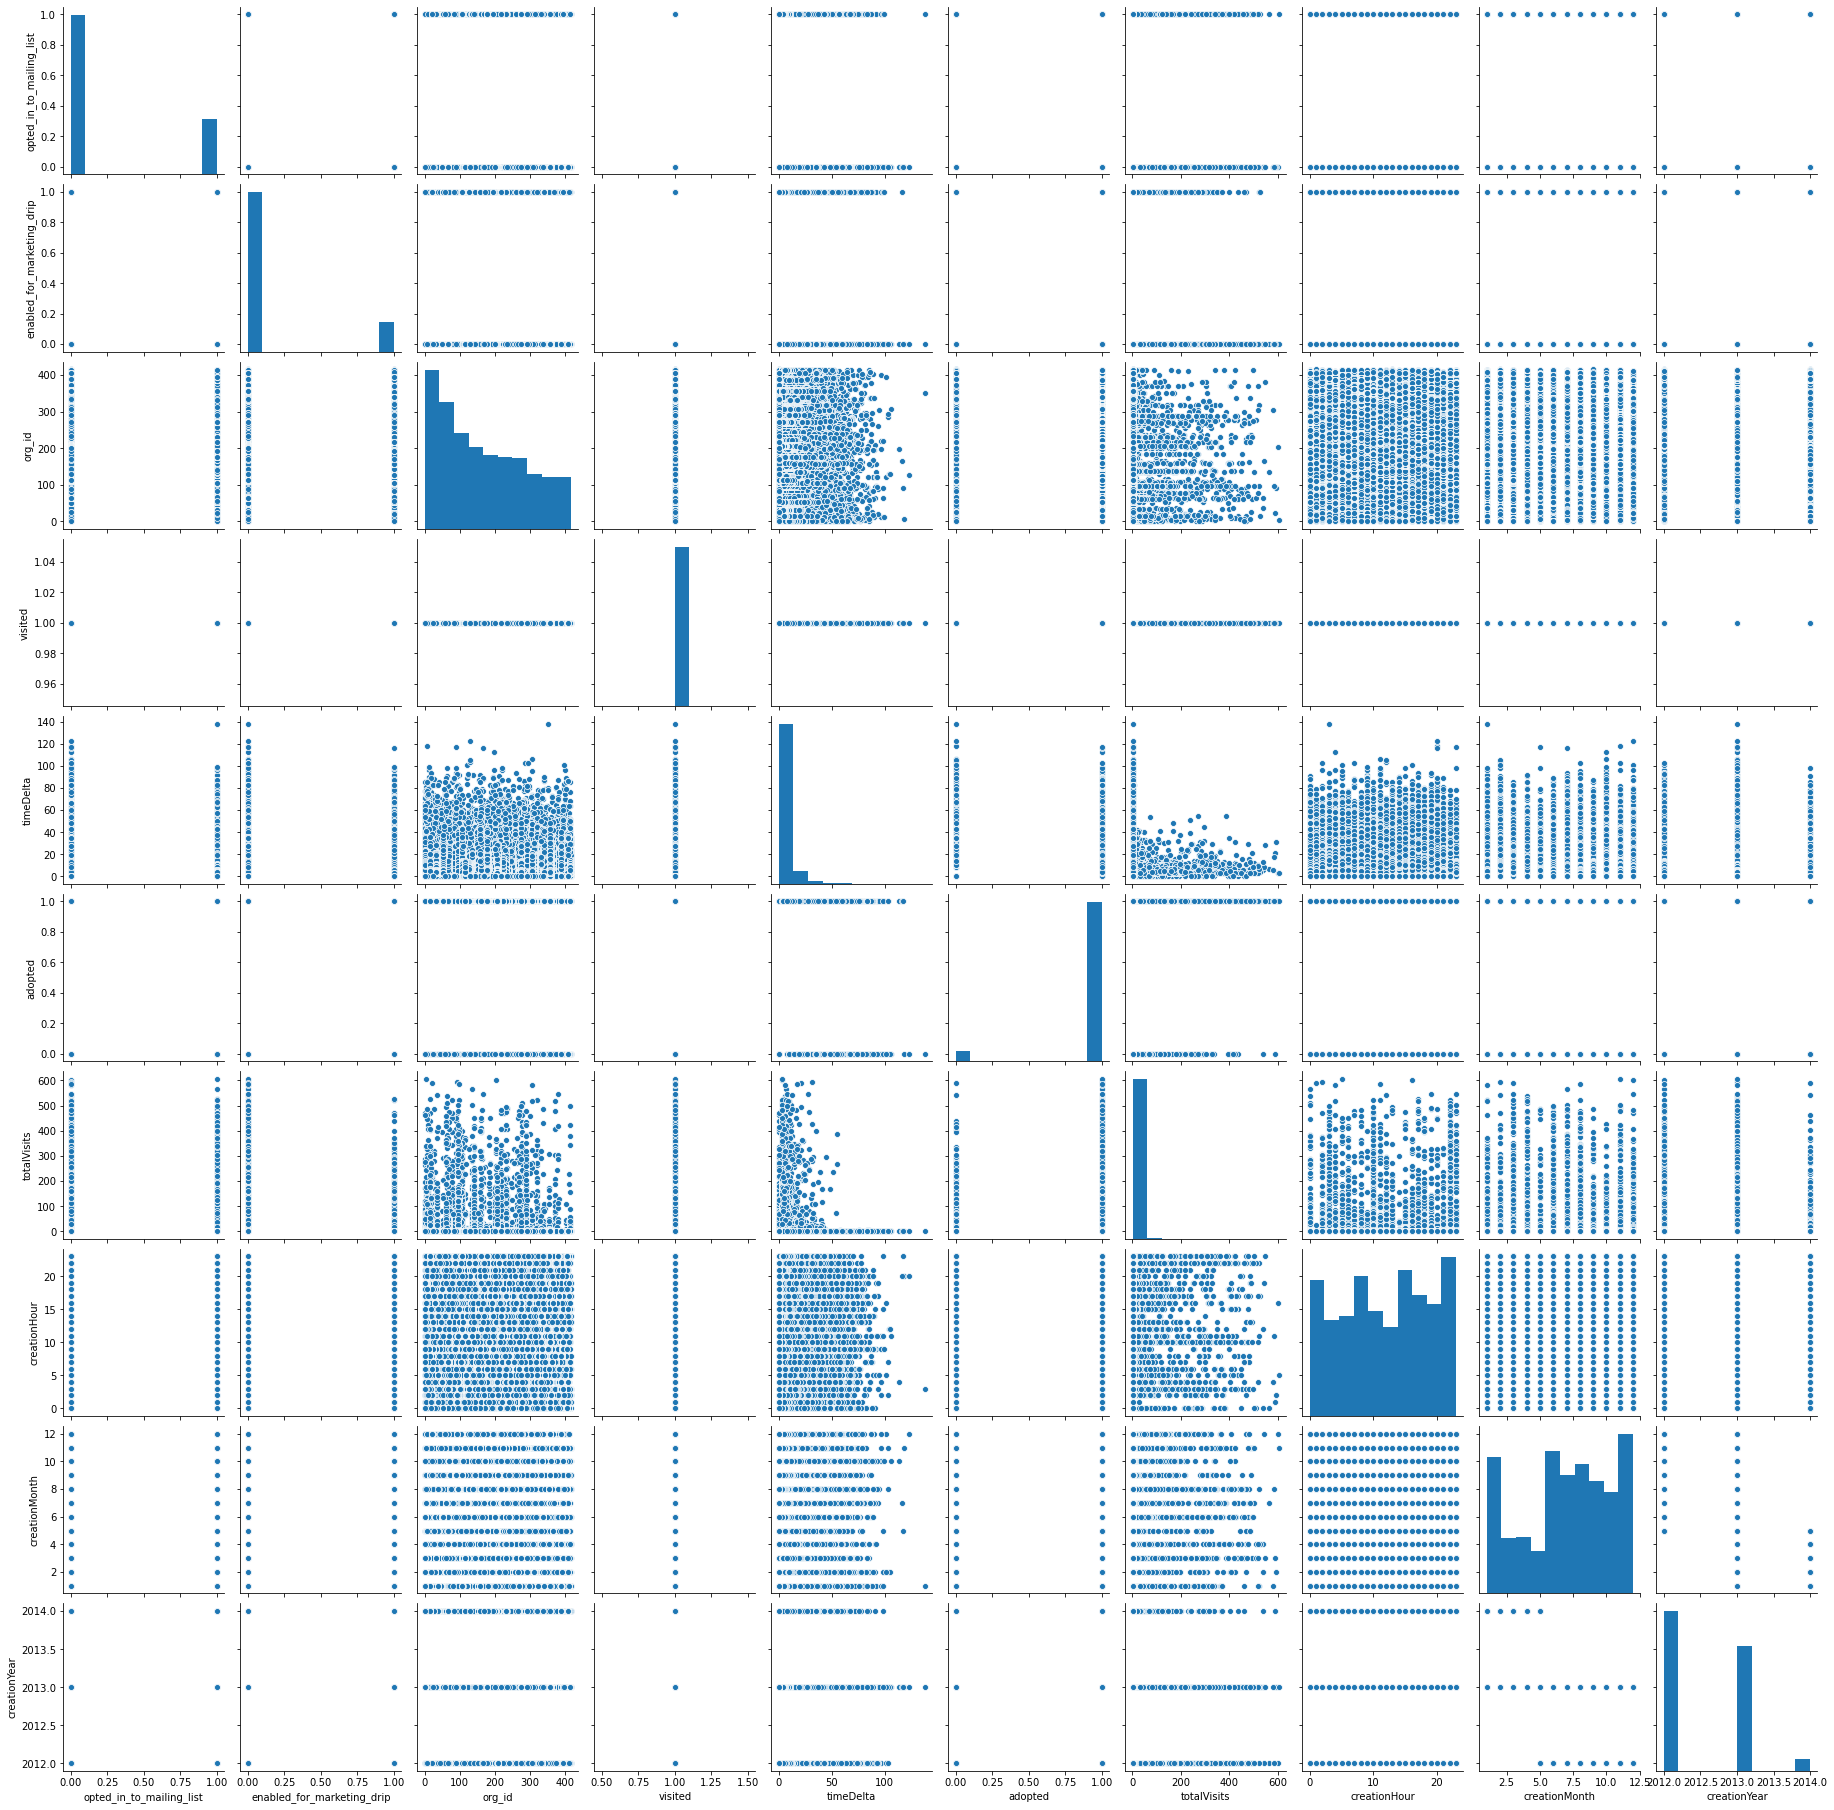

In [34]:
#Now lets do some EDA
_ = sns.pairplot(data=df)

In [35]:
df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,time_stamp,visited,timeDelta,adopted,domain,totalVisits,creationHour,creationMonth,creationYear
0,2014-04-22 03:53:30,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,2014-04-22 03:53:30,1.0,0,0,yahoo,1.0,3,4,2014
1,2013-11-15 03:45:04,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-11-15 03:45:04,1.0,0,0,gustr,1.0,3,11,2013
2,2013-11-15 03:45:04,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-11-29 03:45:04,1.0,0,0,gustr,14.0,3,11,2013
3,2013-11-15 03:45:04,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-12-09 03:45:04,1.0,0,0,gustr,1.0,3,11,2013
4,2013-11-15 03:45:04,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,2013-12-25 03:45:04,1.0,40,0,gustr,1.0,3,11,2013


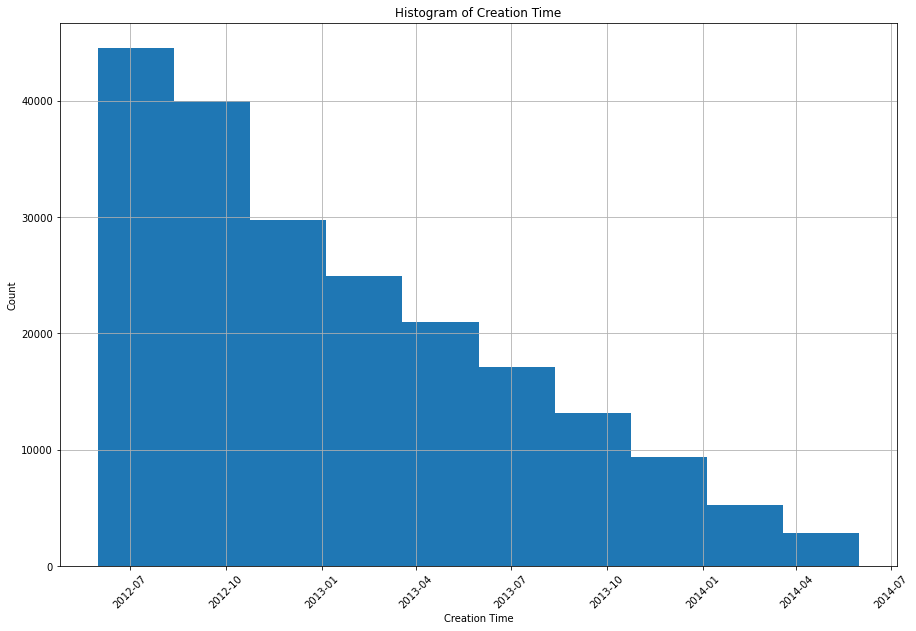

In [36]:
fig = plt.figure(figsize = (15, 10))
df.creation_time.hist()
_ = plt.xticks(rotation = 45)
_ =plt.xlabel('Creation Time')
_ =plt.ylabel('Count')
_ =plt.title('Histogram of Creation Time')

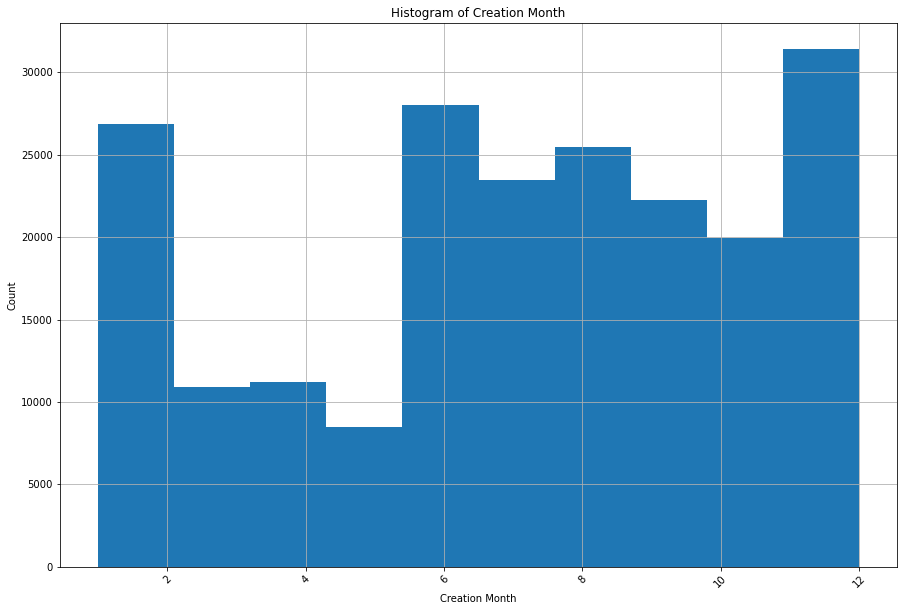

In [37]:
fig = plt.figure(figsize = (15, 10))
_ = plt.xticks(rotation = 45)
df.creationMonth.hist()
_ = plt.title('Histogram of Creation Month')
_ = plt.xlabel('Creation Month')
_ = plt.ylabel('Count')


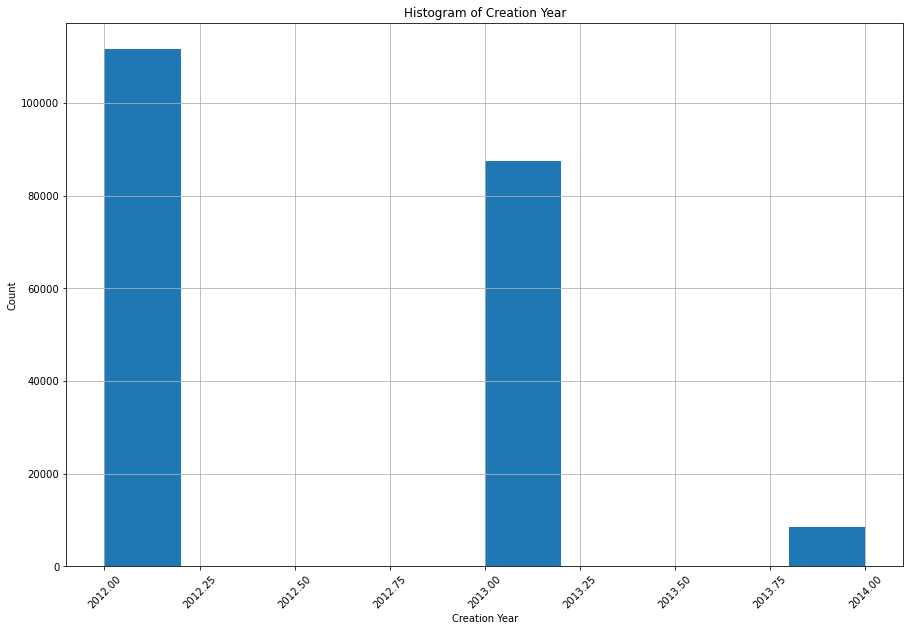

In [38]:
fig = plt.figure(figsize=(15, 10))
_ = plt.xticks(rotation = 45)
_ = plt.title('Histogram of Creation Year')
_ = plt.xlabel('Creation Year')
_ = plt.ylabel('Count')
_ =df.creationYear.hist()

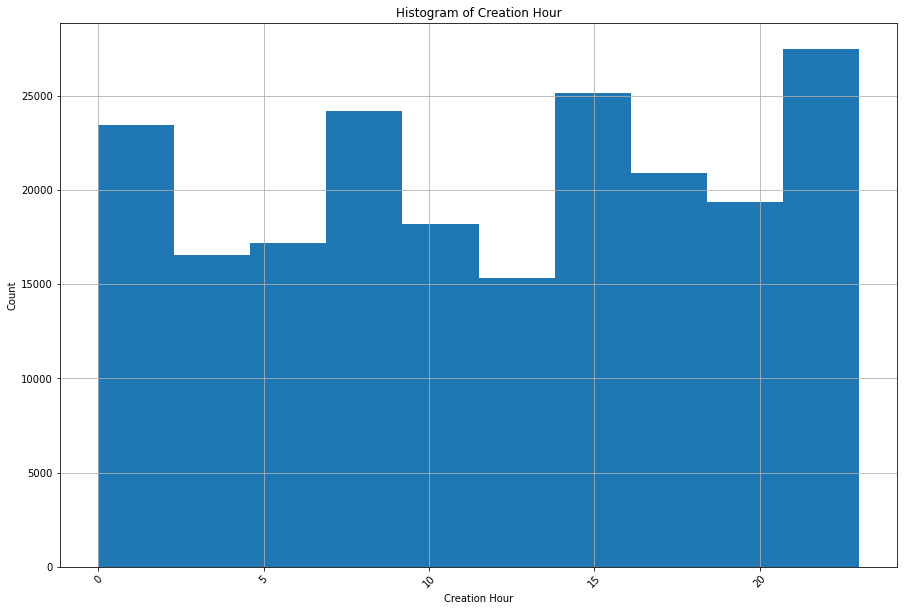

In [39]:
fig = plt.figure(figsize= (15, 10))
_ = plt.xlabel('Creation Hour')
_ = plt.xticks(rotation = 45)
_ = plt.ylabel('Count')
_ = plt.title('Histogram of Creation Hour')
_ =df.creationHour.hist()

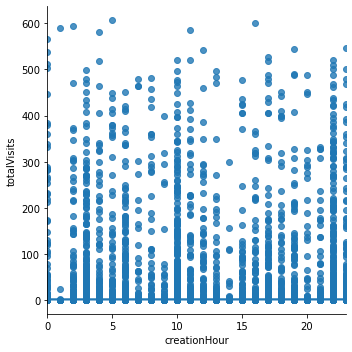

In [40]:
sns.lmplot(data = df, x = 'creationHour', y = 'totalVisits')

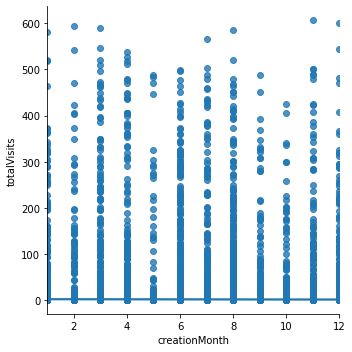

In [41]:
sns.lmplot(data = df, x = 'creationMonth', y = 'totalVisits')

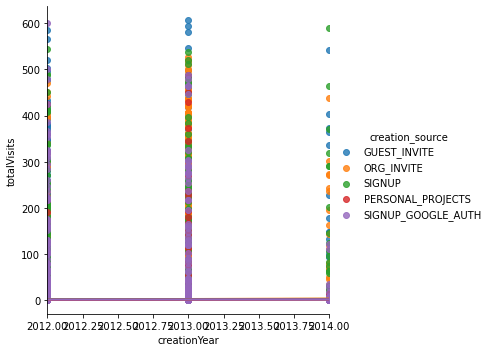

In [42]:
sns.lmplot(data = df, x = 'creationYear', y = 'totalVisits', hue = 'creation_source')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 211093
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   creation_time               207917 non-null  datetime64[ns]
 1   creation_source             207917 non-null  object        
 2   last_session_creation_time  207917 non-null  datetime64[ns]
 3   opted_in_to_mailing_list    207917 non-null  int64         
 4   enabled_for_marketing_drip  207917 non-null  int64         
 5   org_id                      207917 non-null  int64         
 6   time_stamp                  207917 non-null  datetime64[ns]
 7   visited                     207917 non-null  float64       
 8   timeDelta                   207917 non-null  int64         
 9   adopted                     207917 non-null  int64         
 10  domain                      207917 non-null  object        
 11  totalVisits                 207917 non-

In [44]:
#We need to drop the columns that have datatype datetime64. This is fine
#because we have already added the various components of these to additoinal features
X.drop(columns = ['creation_time', 'last_session_creation_time', 'time_stamp'], inplace = True)

In [45]:
#Quick double check there are no null values in the ~800 columns
for col in X.columns:
    if X[col].isnull().sum() > 0:
        print(col)

In [46]:
#Import train_test_split and create the vectors/dfs.
#because the target variable is imbalanced, we need to ensure that the data
# are stratified.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)

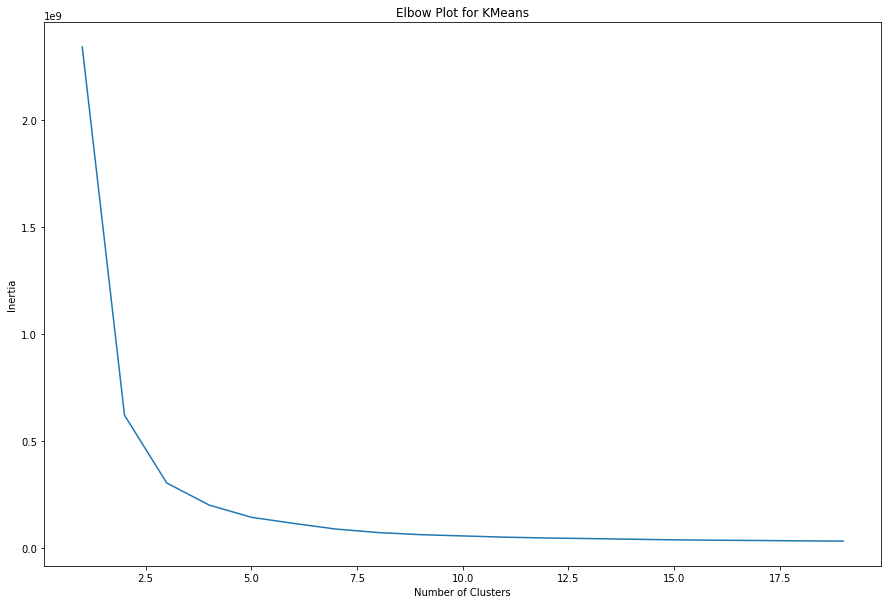

In [47]:
#Now lets try some clustering to see if that can add some value
from sklearn.cluster import KMeans
#Empty list for inertia values
inertia = []
clusters = np.arange(1, 20, 1)
for cluster in clusters:
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit(x_train)
    inertia.append(kmeans.inertia_)
_ = fig = plt.figure(figsize=(15, 10))
_ = plt.plot(clusters, inertia)
_ = plt.xlabel('Number of Clusters')
_ = plt.ylabel('Inertia')
_ = plt.title('Elbow Plot for KMeans')

In [48]:
#Looks like five is a good number 
#Lets create the clusters
kmeans = KMeans(n_clusters = 5)
kmeans.fit(x_train)
clusters = kmeans.predict(x_train)
#Add to the x_train vector
x_train['clusters'] = clusters
#x_test clusters
clusters = kmeans.predict(x_test)
x_test['clusters'] = clusters


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
#Since this is an imbalanced data set, we likely will not want to use 
#logistic regression, so I'll jump right to random forest
rf = RandomForestClassifier()
_ = rf.fit(x_train, y_train)

RandomForestClassifier()

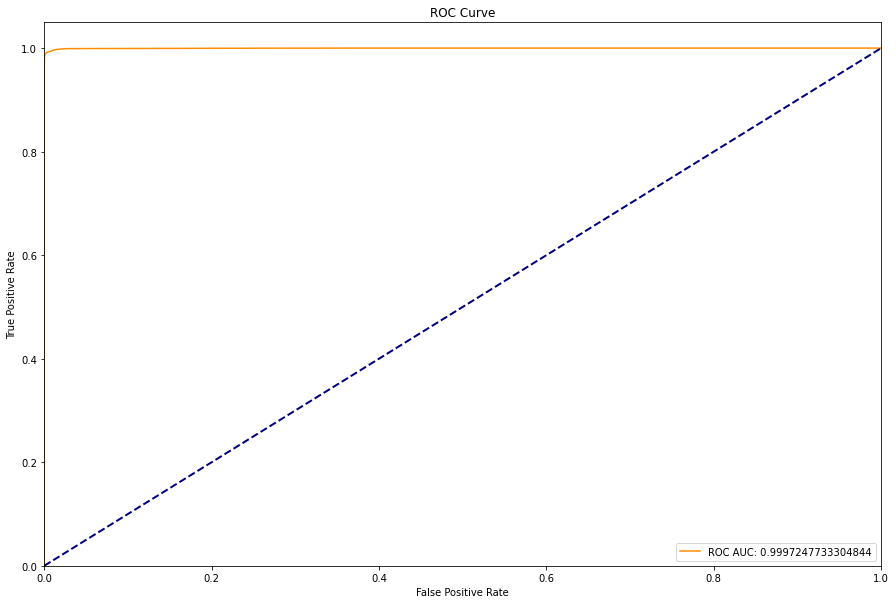

In [54]:
#Make predictions
preds = rf.predict(x_test)
#Get the prediction probabilities for roc_auc
preds_prob = rf.predict_proba(x_test)
#calculate the false positive rate, and true positive rate
fpr, tpr, _ = roc_curve(y_test, preds_prob[:,1])
#Get the area under the receiver operator characteristic curve
roc_auc = auc(fpr, tpr)
#plot that bad-boy and print the auc
fig = plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC AUC: {}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [55]:
#Dang, thats an impressive AUC... Lets get the feature importance into a dictionary
#with the feature names and sort by the value of the importance
featureImportance = dict(zip(x_train.columns, rf.feature_importances_))
sorted_keys = sorted(featureImportance, key = featureImportance.get, reverse = True)
sortedImportance = {}
for key in sorted_keys:
    sortedImportance[key] = featureImportance[key]

In [56]:
#Lets take a look at the most important features.
sortedImportance

{'timeDelta': 0.3824192226462222,
 'org_id': 0.1315310465020173,
 'creationYear': 0.1067904181974912,
 'creationHour': 0.10480772087596776,
 'creationMonth': 0.0891933367059664,
 'clusters': 0.031233128002177098,
 'opted_in_to_mailing_list': 0.01407027857264724,
 'enabled_for_marketing_drip': 0.011417215038596887,
 'creation_source_ORG_INVITE': 0.00910844938958587,
 'domain_gmail': 0.008517593693367012,
 'domain_jourrapide': 0.008163776560697222,
 'creation_source_GUEST_INVITE': 0.007922998287494595,
 'creation_source_SIGNUP': 0.007540174419427466,
 'domain_hotmail': 0.007132211244633001,
 'domain_yahoo': 0.006546652487870906,
 'creation_source_PERSONAL_PROJECTS': 0.006538416503138788,
 'domain_gustr': 0.0064384495528680835,
 'domain_': 0.006268330721058528,
 'creation_source_SIGNUP_GOOGLE_AUTH': 0.00482731194232872,
 'totalVisits': 0.002958728937431678,
 'domain_xcqzb': 0.0015117269667232998,
 'domain_xgmsd': 0.001174710518275282,
 'domain_xjdlv': 0.001125527682547411,
 'domain_cavde'

In [57]:
#In addition to the AUC, we should also take a look at the confusion matirx
#to see how well the classifier does
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds)

array([[ 3066,   152],
       [   44, 48718]], dtype=int64)

In [ ]:
#Only 44 false negatives and 152 false postives is pretty impressive... 